# Analysis of Density inside the Core

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re,glob,os
from scipy import integrate
from numpy import pi as π
import dgutils
from pimcscripts import pimchelp
from collections import defaultdict
from scipy import interpolate
from dgutils import colors as colortools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['notebook'])

figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ρ_col = [colors[0],colors[1],colors[2],colors[3],colors[6],colors[8]]
grey = '#4B4B4B'

import hg_utils
from hg_utils import lab as lab

## Simulation Parameters

In [2]:
ΔR = [0.0,2.0,3.0,4.0]
T = 2.0
w = 3.0
L = 100
sim_params = {'T':T,'canonical':False,'μ':-7.2, 'L':L, 'τ':0.004}

## We load the merged (individual seeds) QMC data for the core density from the data directory

In [3]:
ρ_1d_seeds = {}

for cΔR in ΔR:
    dir_name = f'{hg_utils.base_dir(cΔR,cylinder=True)}'

    # find the appropriate linedensity file and extract the value and headers
    fname = dir_name + os.sep + pimchelp.get_file_list_from_params(**sim_params,base_dir=dir_name,ftype='linedensity')
    headers = pimchelp.getHeadersFromFile(fname)
    x = np.array([float(cx) for cx in headers]) - L/2
    ρ_1d_seeds[lab(cΔR)] = np.loadtxt(fname)
    print(f'ΔR = {cΔR}:  {ρ_1d_seeds[lab(cΔR)].shape}')

ΔR = 0.0:  (200, 200)
ΔR = 2.0:  (100, 200)
ΔR = 3.0:  (205, 200)
ΔR = 4.0:  (151, 200)


## Load the Seed-Averaged Values

In [4]:
reduce_params = {'reduce':'T', 'L':100, 'μ':-7.2}

ρ_1d_qmc = {}
for cΔR in ΔR:
    ρ_1d_qmc[lab(cΔR)] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params, base_dir=hg_utils.base_dir(cΔR),
                                                                       estimator='linedensity'))
    reduce_par = ρ_1d_qmc[lab(cΔR)].params[0]

## Compute the Average Density

### Average the Signal in the Tails

In [5]:
ρₒ_seeds = {}
x_mask_out_right = np.where(x > L/2-2*w)[0]
x_mask_out_left = np.where(x < -L/2+2*w)[0]

for cΔR in ΔR:
    ρ_right = integrate.simpson(ρ_1d_seeds[lab(cΔR)][:,x_mask_out_right],x=x[x_mask_out_right],axis=1)/(x[x_mask_out_right[-1]] - x[x_mask_out_right[0]])
    ρ_left = integrate.simpson(ρ_1d_seeds[lab(cΔR)][:,x_mask_out_left],x=x[x_mask_out_left],axis=1)/(x[x_mask_out_left[-1]] - x[x_mask_out_left[0]])
    ρₒ_seeds[lab(cΔR)] = 0.5*(ρ_right + ρ_left)

0.24970029875113986 0.0010932119396016642


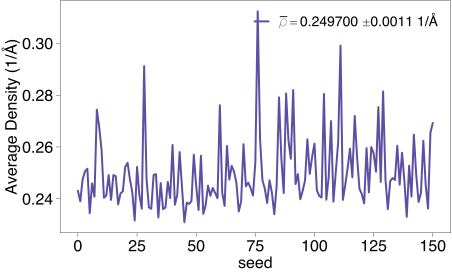

In [6]:
cΔR = 4.0
ave = np.average(ρₒ_seeds[lab(cΔR)])
std = np.std(ρₒ_seeds[lab(cΔR)])/np.sqrt(len(ρₒ_seeds[lab(cΔR)])-1)
plt.plot(ρₒ_seeds[lab(cΔR)], label = r'$\overline{\rho} = $' + f'{ave:.6f} ' + r'$\pm$' + f'{std:.4f} 1/Å')
print(ave,std)
plt.xlabel('seed')
plt.ylabel('Average Density (1/Å)')
plt.legend();

In [7]:
def plot_ρ_1d(_ax,_x,_ρ,_Δρ,idxs,cΔR,_col,label='_nolegend_', line=True, shift=False, ave_ρ=0.0, Δave_ρ=0.0, alpha='80'):
    
    if shift:
        _ρ,_Δρ = shifted_ave(_ρ,_Δρ,ave_ρ, Δave_ρ)
    
    if line:
        _ax.plot(x[:],_ρ[:], ls='-', lw=0.25, color=_col)
    
    _ax.errorbar(x[:],_ρ[:],yerr=_Δρ[:], **plot_params(_col, alpha=alpha), label=label)
    return _ax

In [8]:
def plot_params(color, eb=True, alpha='80'):

    alpha_f = int(alpha,16)/255.0
    _p = {'marker':'o', 'linewidth':0.1, 'color':color, 
          'markerfacecolor':colortools.get_alpha_hex(color,alpha_f)+alpha, 'markersize':2, 
          'markeredgecolor':color, 'linestyle':':', 'markeredgewidth':0.5}
    if eb:
        _p['ecolor'] = color
        _p['elinewidth'] = 0.5
        _p['linestyle'] = 'None'
        _p['barsabove'] = True

    return _p

## Investigate the core density for different seeds

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


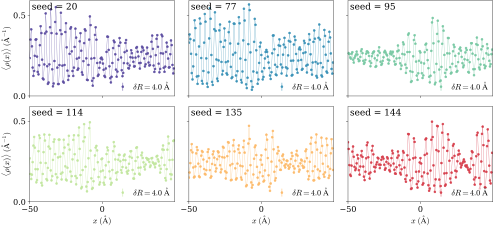

In [10]:
cΔR = 4.0

with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig,axes = plt.subplots(nrows=2,ncols=3,sharex=True, sharey=True, figsize=(2*figsize[0],1.5*figsize[1]),constrained_layout=True)
    trans = mtransforms.ScaledTranslation(2/72, -2/72, fig.dpi_scale_trans)
    
    seed = np.sort(np.random.randint(low=0, high=ρ_1d_seeds[lab(cΔR)].shape[0],size=6))
    for i, ax in enumerate(axes.flat):
        #plot_ρ_1d(ax,*ρ_1d_qmc[lab(0.0)].epdata(reduce_par),range(0,1),cΔR,grey+'80', alpha='11', label=r'$\delta R = 0.0\; {\rm \AA}$')
        
        plot_ρ_1d(ax,x,ρ_1d_seeds[lab(cΔR)][seed[i],:],np.zeros_like(x),range(0,ρ_1d_seeds[lab(cΔR)].shape[1]),
                  cΔR,ρ_col[i], alpha='FF', label=r'$\delta R = 4.0\; {\rm \AA}$')  
        
        
        ax.text(0.0, 1.0, f'seed = {seed[i]}', transform=ax.transAxes + trans, ha='left', va='top')
        ax.legend(loc='lower right', facecolor='w',framealpha=0.8, frameon=True, edgecolor='None', borderpad=0.1)
        ax.set_xlim(-50,49.9)
        ax.set_ylim(0,0.59)
        
    for cax in axes[-1,:]:
        cax.set_xlabel(r'$x\; (\rm \AA)$')
    for cax in axes[:,0]:
        cax.set_ylabel(r'$\langle \rho(x) \rangle\; (\rm \AA^{-1})$')
        
    plt.savefig('../figures/rho_vs_x_seeds.pdf')
    plt.savefig('../figures/rho_vs_x_seeds.svg')

## Compare with the Seed-Averaged Value

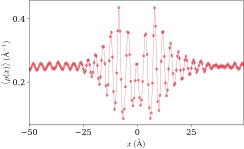

In [11]:
cΔR = 4.0

with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[1]),constrained_layout=True)    
    
    plot_ρ_1d(ax,*ρ_1d_qmc[lab(cΔR)].epdata(reduce_par),range(0,1),cΔR,ρ_col[-1], alpha='80', label=r'$\delta R = 4.0\; {\rm \AA}$')

    ax.set_xlabel(r'$x\; (\rm \AA)$')
    ax.set_ylabel(r'$\langle \rho(x) \rangle\; (\rm \AA^{-1})$')
    ax.set_xlim(-50,49)
    